In [11]:
%matplotlib inline

# REINFORCE on the CartPole Environment

This is an altered version of Jose Nieves Flores Maynez' notebook.

This tutorial shows how to use REINFORCE to train an RL agent on the CartPole-v0 task from the [OpenAI Gym](https://gym.openai.com/).

![cartpole](https://github.com/pytorch/tutorials/blob/main/_static/img/cartpole.gif?raw=true)

The Cartpole environment is a common simple example that is used often for simple RL examples.

In this environment, the task is to balance the pole that is attached to the cart, by moving the cart to either side.
The reward gets incremented for each step (for up to 200 steps) where the pole is not exceeding a set angle and the cart is not touching the sides of the line.
The environment provides four parameters that represent the state of the environment:
Position and velocity of the cart and angle and angular velocity of the pole (see [the documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)).
We will solve this by applying REINFORCE to our RL agent.


### Packages


First, let's import needed packages.

In [12]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Implementation
Since this algorithm relies on updating a function for each existing pair of state and action, environments that have a high state-space become problematic. This is because we can approximate better the actual value of a state-action pair as we visit it more often. However, if we have many states or many actions to take, we distribute our visits among more pairs and it takes much longer to converge to the actual true values. The CartPole environment gives us the position of the cart, its velocity, the angle of the pole and the velocity at the tip of the pole as descriptors of the state. However, all of these are continuous variables. To be able to solve this problem, we need to discretize these states since otherwise, it would take forever to get values for each of the possible combinations of each state, despite them being bounded. The solution is to group several values of each of the variables into the same “bucket” and treat them as similar states. The agent implemented for this problem uses 3, 3, 6, and 6 buckets respectively.

In [13]:
"""
Base code taken from:
https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py
"""

class CartPoleQAgent():
    def __init__(self, buckets=(3, 3, 6, 6),
                 num_episodes=500, min_lr=0.01,
                 discount=0.99, decay=25, discretize=False):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        # self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay
        self.discretize = discretize

        self.env = gym.make('CartPole-v0')

        # Theta is added as with the same size as state (4 in our case)
        self.theta = np.random.rand(self.env.observation_space.shape[0])

        # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]

        #
        self.steps = np.zeros(self.num_episodes)

    def discretize_state(self, obs):
        """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the
        Q-table can be smaller and more easily filled.

        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.

        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller
                             than n where n is the number in the same position
                             in the buckets list.
        """
        if not self.discretize:
            return obs
        discretized = list()
        for i in range(len(obs)):
            scaling = ((obs[i] + abs(self.lower_bounds[i]))
                       / (self.upper_bounds[i] - self.lower_bounds[i]))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def get_learning_rate(self, t):
        """Gets value for learning rate. It declines as we advance in episodes."""
        # Learning rate also declines as we add more episodes
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def plot_learning(self):
        """
        Plots the number of steps at each episode and prints the
        amount of times that an episode was successfully completed.
        """
        sns.lineplot(data=self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] == 200:
                t+=1
        print(t, "episodes were successfully completed.")


    def run(self):
        """Runs an episode while displaying the cartpole environment."""
        self.env = gym.wrappers.Monitor(self.env,'cartpole')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state

        return t

## Choosing an Action by it's theta values and the probabilities.
- The red part is **y**
- The blue part is the probability of a0 **pa0**


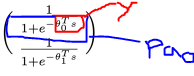


(see Week 3 Page 24)

In [14]:
class CartPoleQAgent(CartPoleQAgent):
    def get_probability(self, state):
        logits = np.dot(state, self.theta)
        return 1 / (1 + np.exp(-logits))

    def choose_action(self, current_state):
        return np.random.choice(self.env.action_space.n, p=self.get_probabilities(current_state))
    
    def get_probabilities(self, current_state):
        pa0 = self.get_probability(current_state)
        return [pa0, 1 - pa0]

## Calculate Estimated Return
The estimated return per step in episode looks like this:


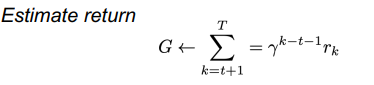

(see Week 3 Page 25)

that's what we need to implement in reverse to have an episode reward we can add as sum.

In [15]:
class CartPoleQAgent(CartPoleQAgent):
    def calculate_estimated_returns(self, rewards):
        estimated_returns = []
        T = len(rewards)
        for t in range(T):
            estimated_return_t = 0
            for k in range(t+1, T):
                d = math.pow(self.discount, k - t - 1)
                estimated_return_t += d * rewards[k]
            estimated_returns.append(estimated_return_t)
        return estimated_returns
    
    def calculate_estimated_returns_v2(self, rewards):
        estimated_returns = []
        T = len(rewards)
        # Loop over each step in the episode in reverse
        for t in reversed(range(T)):
            estimated_return_t = 0 
            for k in range(t, T):
                estimated_return_t += (self.discount ** (k - t)) * rewards[k]
            estimated_returns.insert(0, estimated_return_t)
        return estimated_returns
    
    def calculate_estimated_returns_v3(self, rewards):
        G = 0
        T = len(rewards)
        estimated_returns = []
        for t in reversed(range(T)):
            G = G * self.discount + rewards[t]
            estimated_returns.insert(0, G)
        return estimated_returns

## Calculate the Policy Gradient
We have a logistic policy gradient which has to be calculated
The policy pi(a|s, theta) is in our case the `log_function` (see implementation)


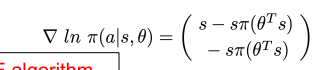


(see Week 3 Page 24)

In [16]:
class CartPoleQAgent(CartPoleQAgent):
    def calculate_policy_gradient(self, state, action):
        probability = self.get_probabilities(state)[action]
        gradient = - np.array(state) * probability
        return gradient if action == 1 else (np.array(state) - gradient)

## Update Theta
Here the thetas need to be updated (gradient update)
- **alpha** --> `self.learning_rate`
- **theta^t** --> `np.pow(self.discount, t)`
- **G** --> `estimated_returns[t]`
- **delta_pi(a|s, theta)** --> `gradient[i]`


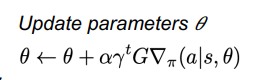


(see Week 3 Page 25)



In [17]:
class CartPoleQAgent(CartPoleQAgent):
    def update_theta(self, states, actions, estimated_returns):
        for t in range(len(states)):
            gradient = self.calculate_policy_gradient(states[t], actions[t])
            #print('Gradient:', gradient)
            for i in range(len(self.theta)):
                self.theta[i] += self.learning_rate * np.power(self.discount, t) * estimated_returns[t] * gradient[i]

## Update Theta V2
This is another update theta formula found in the internet (works much better than the one above)

In [18]:
class CartPoleQAgent(CartPoleQAgent):    
    def update_theta_v2(self, states, actions, estimated_returns):
        for t in range(len(states)):
            state_t = states[t]
            action_t = actions[t]
            action_prob_t = self.get_probability(state_t)
            # Gradient of the log probability (sigmoid function derivative)
            gradient = state_t[action_t] - action_prob_t
            # Update policy parameters
            self.theta += self.learning_rate * estimated_returns[t] * np.power(self.discount, t) * gradient

In [19]:
class CartPoleQAgent(CartPoleQAgent):
    def train(self):
        # Looping for each episode
        for e in range(self.num_episodes):
            # Initializes the state
            current_state = self.discretize_state(self.env.reset()[0])

            self.learning_rate = self.get_learning_rate(e)
            done = False

            states = []
            actions = []
            rewards = []

            # Looping for each step
            while not done:
                self.steps[e] += 1
                # Choose A from S
                action = self.choose_action(current_state)
                # Take action
                obs, reward, done, _, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                # save states, actions and rewards
                # or is here only done to append all lists in one line.
                states.append(current_state) or actions.append(action) or rewards.append(reward)
                current_state = new_state
            estimated_returns = self.calculate_estimated_returns_v3(rewards)
            self.update_theta(states, actions, estimated_returns)
            print("Episode {}: Total Reward: {}".format(e + 1, sum(rewards)))
        print('Finished training!')

C:\Users\axgno01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\axgno01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\axgno01\AppData\Local\Temp\ipykernel_13940\605668524.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-logits))


Episode 1: Total Reward: 13.0
Episode 2: Total Reward: 142.0
Episode 3: Total Reward: 108.0
Episode 4: Total Reward: 53.0
Episode 5: Total Reward: 48.0
Episode 6: Total Reward: 130.0
Episode 7: Total Reward: 135.0
Episode 8: Total Reward: 93.0
Episode 9: Total Reward: 45.0
Episode 10: Total Reward: 96.0
Episode 11: Total Reward: 58.0
Episode 12: Total Reward: 118.0
Episode 13: Total Reward: 52.0
Episode 14: Total Reward: 152.0
Episode 15: Total Reward: 85.0
Episode 16: Total Reward: 53.0
Episode 17: Total Reward: 53.0
Episode 18: Total Reward: 68.0
Episode 19: Total Reward: 58.0
Episode 20: Total Reward: 51.0
Episode 21: Total Reward: 95.0
Episode 22: Total Reward: 57.0
Episode 23: Total Reward: 62.0
Episode 24: Total Reward: 76.0
Episode 25: Total Reward: 164.0
Episode 26: Total Reward: 114.0
Episode 27: Total Reward: 59.0
Episode 28: Total Reward: 92.0
Episode 29: Total Reward: 52.0
Episode 30: Total Reward: 96.0
Episode 31: Total Reward: 54.0
Episode 32: Total Reward: 102.0
Episode 

Episode 52: Total Reward: 215.0
Episode 53: Total Reward: 81.0
Episode 54: Total Reward: 95.0
Episode 55: Total Reward: 54.0
Episode 56: Total Reward: 120.0
Episode 57: Total Reward: 96.0
Episode 58: Total Reward: 60.0
Episode 59: Total Reward: 61.0
Episode 60: Total Reward: 112.0
Episode 61: Total Reward: 52.0
Episode 62: Total Reward: 45.0
Episode 63: Total Reward: 90.0
Episode 64: Total Reward: 55.0
Episode 65: Total Reward: 74.0
Episode 66: Total Reward: 94.0
Episode 67: Total Reward: 106.0
Episode 68: Total Reward: 151.0
Episode 69: Total Reward: 152.0
Episode 70: Total Reward: 60.0
Episode 71: Total Reward: 64.0
Episode 72: Total Reward: 74.0
Episode 73: Total Reward: 69.0
Episode 74: Total Reward: 60.0
Episode 75: Total Reward: 92.0
Episode 76: Total Reward: 46.0
Episode 77: Total Reward: 124.0
Episode 78: Total Reward: 73.0
Episode 79: Total Reward: 88.0
Episode 80: Total Reward: 48.0
Episode 81: Total Reward: 82.0
Episode 82: Total Reward: 86.0
Episode 83: Total Reward: 45.0
E

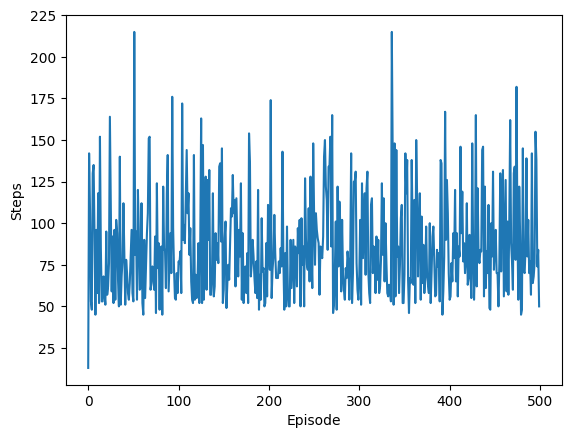

0 episodes were successfully completed.


In [20]:
def load_reinforce():
    agent = CartPoleQAgent(discretize=False)
    agent.train()
    agent.plot_learning()

    return agent

agent = load_reinforce()